In [4]:
from p2psimpy.consts import MBit
from p2psimpy.simulation import BaseSimulation

sim = BaseSimulation()
sim.add_peers(31)
sim.run(10400)

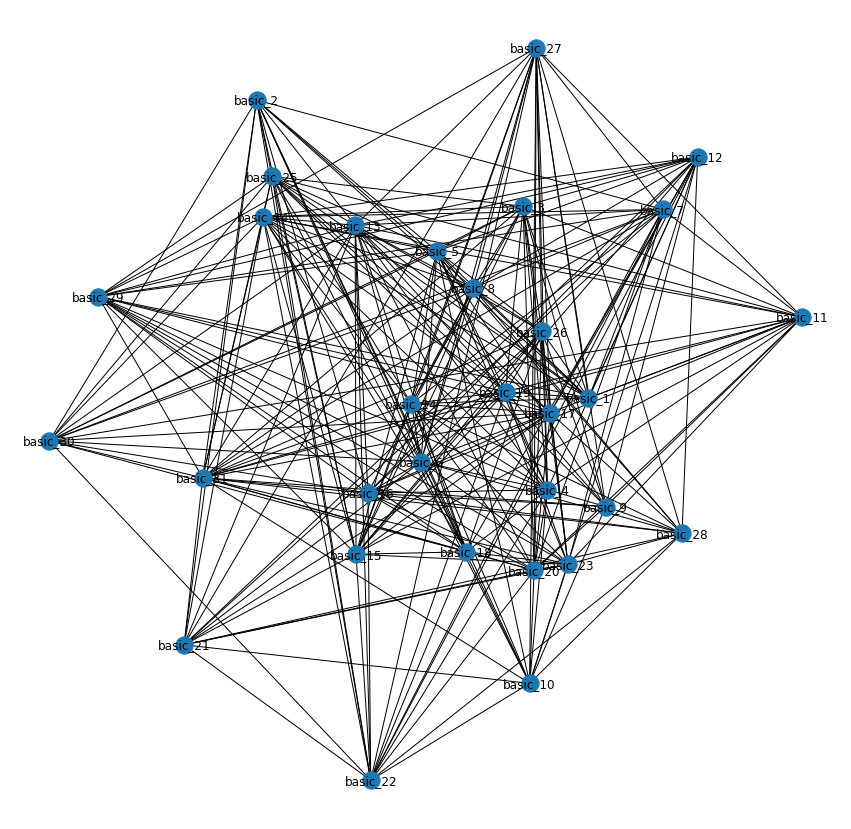

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
from networkx.drawing.nx_agraph import graphviz_layout

from time import time, sleep


G = sim.get_graph()
fig = plt.figure(figsize=(15, 15))
plt.axis('off')
#pos = nx.shell_layout(G)
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(G, pos)

In [5]:
# Draw histogram of the degree 
G.degree()

DegreeView({'basic_1': 20, 'basic_23': 17, 'basic_9': 19, 'basic_7': 21, 'basic_11': 15, 'basic_26': 19, 'basic_12': 14, 'basic_8': 20, 'basic_22': 15, 'basic_10': 16, 'basic_28': 15, 'basic_4': 17, 'basic_20': 15, 'basic_24': 18, 'basic_18': 15, 'basic_31': 16, 'basic_27': 19, 'basic_14': 15, 'basic_25': 17, 'basic_2': 17, 'basic_3': 15, 'basic_30': 18, 'basic_5': 16, 'basic_21': 14, 'basic_16': 19, 'basic_15': 14, 'basic_29': 20, 'basic_17': 18, 'basic_13': 18, 'basic_6': 17, 'basic_19': 19})

In [ ]:
# Investigate the topology more. 

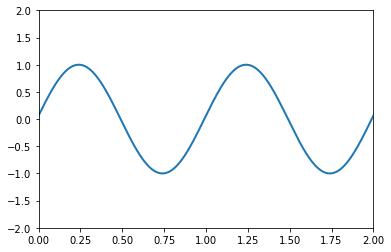

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, 
                               blit=True)

HTML(anim.to_jshtml())

In [ ]:
# - Running an application on top of the network 

In [ ]:
# 1. Form a network topology 
'''
Options:
 a. The topology is formed with this rules: 
  - Any other rules? 
 Change the network topology 
 b. How fanout affect it? 
'''
# 2. Decide on the number of peers and how they are connected and finding each other.
"""
a. Byzantine nodes 
b. Crashing nodes 
c. Slowdowns 
"""
# Add dissemination layer 

# 3. Adding storage on top of the network layer 

# 4. Computation tasks for the peers 

# Incentives experimetns 

# Sybil nodes added


In [5]:
from p2psimpy.services.base import BaseRunner
from dataclasses import dataclass


class Test(BaseRunner):
    pass 

@dataclass 
class PeerConfig:
    name: str = "Peer_a" 

@dataclass 
class Peer:
    config: PeerConfig
    
pc = PeerConfig()
p = Peer(pc)
    
t = Test(p, pc)
repr(t)





'<Test Peer_a>'

In [14]:
p = [Peer, PeerConfig]

In [15]:
c = Peer(pc)

In [17]:
type(c) in p

True

In [23]:
GossipMessage.__name__.lower()

'gossipmessage'

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [1]:
# Message gossip
from p2psimpy.services.base import BaseHandler, BaseRunner, MockHandler
from p2psimpy.peer import Peer
from p2psimpy.storage import Storage
from p2psimpy.messages import BaseMessage

from attr import dataclass
from random import choice


class GossipMessage(BaseMessage):

    def __init__(self, sender, data, ttl):
        super().__init__(sender, data)
        self.ttl = ttl

class TxMessage(GossipMessage): pass
class BlockMessage(GossipMessage): pass
        
@dataclass
class GossipConfig:
    fanout: int


class GossipService(BaseHandler):
    """
    Simple gossip service to handle gossip messages and rely them to neighbors. 
    """

    def __init__(self, peer, config):
        super().__init__(peer, config)

    def handle_message(self, msg):
        if isinstance(msg, GossipMessage):
            if msg.ttl > 0:
                # Rely message further, modify the message
                sender = msg.sender
                msg.sender = self.peer
                msg.ttl -= 1
                self.peer.gossip(msg, self.config.fanout, {sender})

    @property
    def messages(self):
        return GossipMessage,


class TxGossipService(GossipService):

    def __init__(self, peer, config):
        super().__init__(peer, config)
        self.peer.add_storage('tx_store', Storage())
    
    def handle_message(self, msg):
        self.peer.store('tx_store', msg.data.tx_id, msg)
        super().handle_message(msg)
    
    @property
    def messages(self):
        return TxMessage,


@dataclass
class MonetaryTransaction:
    sender: str
    receiver: str
    amount: int
    tx_id: str


@dataclass
class TransactionProducerConfig:
    receivers: list
    tx_rate: int
    init_ttl: int
    init_fanout: int
    init_timeout: int


class TransactionProducer(BaseRunner):

    def __init__(self, peer, config: TransactionProducerConfig):
        super().__init__(peer, config)
        # calculate tx_interval:
        self.tx_interval = 1000 / self.config.tx_rate
        self.counter = 1 

    def produce_transaction(self):
        # select receiver
        receiver = choice(self.config.receivers)
        tx = MonetaryTransaction(self.peer.name, receiver, 1, self.peer.name +"_"+ str(self.counter))
        # gossip the trasaction to the network
        self.counter += 1
        msg = TxMessage(self.peer, tx, self.config.init_ttl)
        self.peer.gossip(msg, self.config.init_fanout)
        

    def run(self):
        yield self.env.timeout(self.config.init_timeout)
        while True:
            self.produce_transaction()
            yield self.env.timeout(self.tx_interval)


@dataclass
class MockConfig:
    messages: list

In [2]:
from p2psimpy.logger import init_log
init_log()

In [4]:
from p2psimpy.logger import init_log, reset_log
reset_log()


In [19]:
SIM_DURATION = 100

import simulus

class Cable(object):
    """This class represents the propagation through a cable."""
    def __init__(self, sim, delay):
        self.sim = sim
        self.delay = delay
        self.store = sim.store()

    def latency(self, value):
        sim.sleep(self.delay)
        self.store.put(obj=value)

    def put(self, value):
        sim.process(self.latency, value)

    def get(self):
        return self.store.get()

def sender(sim, cable):
    """A process which randomly generates messages."""
    while True:
        # wait for next transmission
        sim.sleep(5)
        cable.put('Sender sent this at %d' % sim.now)

def receiver(sim, cable):
    """A process which consumes messages."""
    while True:
        # Get event for message pipe
        msg = cable.get()
        print('Received this at %d while %s' % (sim.now, msg))

# Setup and start the simulation
print('Event Latency')
sim = simulus.simulator()

cable = Cable(sim, 10)
sim.process(sender, sim, cable)
sim.process(receiver, sim, cable)

sim.run(until=SIM_DURATION)

Event Latency
Received this at 15 while Sender sent this at 5
Received this at 20 while Sender sent this at 10
Received this at 25 while Sender sent this at 15
Received this at 30 while Sender sent this at 20
Received this at 35 while Sender sent this at 25
Received this at 40 while Sender sent this at 30
Received this at 45 while Sender sent this at 35
Received this at 50 while Sender sent this at 40
Received this at 55 while Sender sent this at 45
Received this at 60 while Sender sent this at 50
Received this at 65 while Sender sent this at 55
Received this at 70 while Sender sent this at 60
Received this at 75 while Sender sent this at 65
Received this at 80 while Sender sent this at 70
Received this at 85 while Sender sent this at 75
Received this at 90 while Sender sent this at 80
Received this at 95 while Sender sent this at 85


In [20]:
import simpy


SIM_DURATION = 100


class Cable(object):
    """This class represents the propagation through a cable."""
    def __init__(self, env, delay):
        self.env = env
        self.delay = delay
        self.store = simpy.Store(env)

    def latency(self, value):
        yield self.env.timeout(self.delay)
        self.store.put(value)

    def put(self, value):
        self.env.process(self.latency(value))

    def get(self):
        return self.store.get()


def sender(env, cable):
    """A process which randomly generates messages."""
    while True:
        # wait for next transmission
        yield env.timeout(5)
        cable.put('Sender sent this at %d' % env.now)


def receiver(env, cable):
    """A process which consumes messages."""
    while True:
        # Get event for message pipe
        msg = yield cable.get()
        print('Received this at %d while %s' % (env.now, msg))


# Setup and start the simulation
print('Event Latency')
env = simpy.Environment()

cable = Cable(env, 10)
env.process(sender(env, cable))
env.process(receiver(env, cable))

env.run(until=SIM_DURATION)

Event Latency
Received this at 15 while Sender sent this at 5
Received this at 20 while Sender sent this at 10
Received this at 25 while Sender sent this at 15
Received this at 30 while Sender sent this at 20
Received this at 35 while Sender sent this at 25
Received this at 40 while Sender sent this at 30
Received this at 45 while Sender sent this at 35
Received this at 50 while Sender sent this at 40
Received this at 55 while Sender sent this at 45
Received this at 60 while Sender sent this at 50
Received this at 65 while Sender sent this at 55
Received this at 70 while Sender sent this at 60
Received this at 75 while Sender sent this at 65
Received this at 80 while Sender sent this at 70
Received this at 85 while Sender sent this at 75
Received this at 90 while Sender sent this at 80
Received this at 95 while Sender sent this at 85


In [15]:
import simulus

rank = simulus.sync.comm_rank()
psize = simulus.sync.comm_size()

print('rank=%d, psize=%d' % (rank, psize))


rank=0, psize=1


In [32]:
import simulus

from functools import partial
print = partial(print, flush=True)

def p(sim, idx, mbox):
    while True:
        msg = mbox.recv(isall=False)
        print("%g: '%s' rcvd msg '%s'" % (sim.now, sim.name, msg))
        sim.sync().send(sim, 'mb%d'% ((idx+1)%nnodes), msg)

nnodes = 1
sims = []
for i in range(nnodes):
    sim = simulus.simulator('sim%d'%i)
    sims.append(sim)
    mbox = sim.mailbox('mb%d'%i, 1)
    sim.process(p, sim, i, mbox)

g = simulus.sync(sims, enable_smp=True)
g.send(sims[0], 'mb0', 'hello') # send initial message to start circulation
g.run(30)
g.run(5, show_runtime_report=True)

1: 'sim0' rcvd msg 'hello'
2: 'sim0' rcvd msg 'hello'
3: 'sim0' rcvd msg 'hello'
4: 'sim0' rcvd msg 'hello'
5: 'sim0' rcvd msg 'hello'
6: 'sim0' rcvd msg 'hello'
7: 'sim0' rcvd msg 'hello'
8: 'sim0' rcvd msg 'hello'
9: 'sim0' rcvd msg 'hello'
10: 'sim0' rcvd msg 'hello'
11: 'sim0' rcvd msg 'hello'
12: 'sim0' rcvd msg 'hello'
13: 'sim0' rcvd msg 'hello'
14: 'sim0' rcvd msg 'hello'
15: 'sim0' rcvd msg 'hello'
16: 'sim0' rcvd msg 'hello'
17: 'sim0' rcvd msg 'hello'
18: 'sim0' rcvd msg 'hello'
19: 'sim0' rcvd msg 'hello'
20: 'sim0' rcvd msg 'hello'
21: 'sim0' rcvd msg 'hello'
22: 'sim0' rcvd msg 'hello'
23: 'sim0' rcvd msg 'hello'
24: 'sim0' rcvd msg 'hello'
25: 'sim0' rcvd msg 'hello'
26: 'sim0' rcvd msg 'hello'
27: 'sim0' rcvd msg 'hello'
28: 'sim0' rcvd msg 'hello'
29: 'sim0' rcvd msg 'hello'
30: 'sim0' rcvd msg 'hello'
31: 'sim0' rcvd msg 'hello'
32: 'sim0' rcvd msg 'hello'
33: 'sim0' rcvd msg 'hello'
34: 'sim0' rcvd msg 'hello'
*********** sync group performance metrics ***********
pa

In [11]:
import simulus

def p(sim, mbox, mbname):
    while True:
        msg = mbox.recv(isall=False)
        print("%g: '%s' rcvd msg '%s'" % (sim.now, sim.name, msg))
        sim.sync().send(sim, mbname, 'pong' if msg=='ping' else 'ping')

sim1 = simulus.simulator('sim1')
mb1 = sim1.mailbox('mb1', 1)
sim1.process(p, sim1, mb1, 'mb2')

sim2 = simulus.simulator('sim2')
mb2 = sim2.mailbox('mb2', 1)
sim2.process(p, sim2, mb2, 'mb1')

mb1.send('ping') # send initial message to start ping-ponging

g = simulus.sync([sim1, sim2], enable_smp=True)
g.run(10, show_runtime_report=True)

2: 'sim2' rcvd msg 'pong'
4: 'sim2' rcvd msg 'pong'
6: 'sim2' rcvd msg 'pong'
8: 'sim2' rcvd msg 'pong'
1: 'sim1' rcvd msg 'ping'
3: 'sim1' rcvd msg 'ping'
5: 'sim1' rcvd msg 'ping'
7: 'sim1' rcvd msg 'ping'
9: 'sim1' rcvd msg 'ping'
*********** sync group performance metrics ***********
partitioning information (simulator assignment):
  'sim1' on rank 0 proc 0
  'sim2' on rank 0 proc 1
execution time: 0.186818
scheduled events: 12 (rate=64.2336)
executed events: 11 (rate=58.8808)
cancelled events: 0
created processes: 2
finished processes: 0
cancelled processes: 0
process context switches: 11


In [10]:
import simulus

def p(sim, mbox, mbname):
    while True:
        msg = mbox.recv(isall=False)
        print("%g: '%s' rcvd msg '%s'" % (sim.now, sim.name, msg))
        sim.sync().send(sim, mbname, 'pong' if msg=='ping' else 'ping')

sim1 = simulus.simulator('sim1')
mb1 = sim1.mailbox('mb1', 1)
sim1.process(p, sim1, mb1, 'mb2')

sim2 = simulus.simulator('sim2')
mb2 = sim2.mailbox('mb2', 1)
sim2.process(p, sim2, mb2, 'mb1')

mb1.send('ping') # send initial message to start ping-ponging

g = simulus.sync([sim1, sim2])
g.run(10)


1: 'sim1' rcvd msg 'ping'
2: 'sim2' rcvd msg 'pong'
3: 'sim1' rcvd msg 'ping'
4: 'sim2' rcvd msg 'pong'
5: 'sim1' rcvd msg 'ping'
6: 'sim2' rcvd msg 'pong'
7: 'sim1' rcvd msg 'ping'
8: 'sim2' rcvd msg 'pong'
9: 'sim1' rcvd msg 'ping'


Event Latency
Received this at 15 while Sender sent this at 5
Received this at 20 while Sender sent this at 10
Received this at 25 while Sender sent this at 15
Received this at 30 while Sender sent this at 20
Received this at 35 while Sender sent this at 25
Received this at 40 while Sender sent this at 30
Received this at 45 while Sender sent this at 35
Received this at 50 while Sender sent this at 40
Received this at 55 while Sender sent this at 45
Received this at 60 while Sender sent this at 50
Received this at 65 while Sender sent this at 55
Received this at 70 while Sender sent this at 60
Received this at 75 while Sender sent this at 65
Received this at 80 while Sender sent this at 70
Received this at 85 while Sender sent this at 75
Received this at 90 while Sender sent this at 80
Received this at 95 while Sender sent this at 85


In [3]:
from p2psimpy.simulation import BaseSimulation

peer_num = 60


gossip_config = GossipConfig(fanout=5)
receivers = ['basic_'+str(i+1) for i in range(peer_num)]
tx_producer_config = TransactionProducerConfig(receivers=receivers, tx_rate=3, 
                                               init_ttl=3, init_fanout=5, init_timeout=2000) 

sim = BaseSimulation()
# add services to the simulation
sim.add_peer_service('basic', TxGossipService, gossip_config)
sim.add_peer_service('basic', TransactionProducer, tx_producer_config)
sim.add_peer_service('bootstrap', MockHandler, MockConfig(messages=[GossipMessage, TxMessage]))

sim.init_bootstrap_servers()

sim.add_peers(peer_num)
sim.start_all_peers()

sim.run(10000) # in ms 


In [6]:
# Investigate the peer storage 
sim.peers['basic'][0].storage['tx_store'].txs

# Visualize the transactions 

{'basic_25_1': <TxMessage>,
 'basic_20_1': <TxMessage>,
 'basic_30_1': <TxMessage>,
 'basic_14_1': <TxMessage>,
 'basic_9_1': <TxMessage>,
 'basic_10_1': <TxMessage>,
 'basic_8_1': <TxMessage>,
 'basic_17_1': <TxMessage>,
 'basic_18_1': <TxMessage>,
 'basic_22_1': <TxMessage>,
 'basic_16_1': <TxMessage>,
 'basic_24_1': <TxMessage>,
 'basic_19_1': <TxMessage>,
 'basic_40_1': <TxMessage>,
 'basic_45_1': <TxMessage>,
 'basic_56_1': <TxMessage>,
 'basic_34_1': <TxMessage>,
 'basic_33_1': <TxMessage>,
 'basic_7_1': <TxMessage>,
 'basic_50_1': <TxMessage>,
 'basic_29_1': <TxMessage>,
 'basic_58_1': <TxMessage>,
 'basic_32_1': <TxMessage>,
 'basic_6_1': <TxMessage>,
 'basic_13_1': <TxMessage>,
 'basic_48_1': <TxMessage>,
 'basic_23_1': <TxMessage>,
 'basic_55_1': <TxMessage>,
 'basic_5_1': <TxMessage>,
 'basic_54_1': <TxMessage>,
 'basic_49_1': <TxMessage>,
 'basic_42_1': <TxMessage>,
 'basic_41_1': <TxMessage>,
 'basic_36_1': <TxMessage>,
 'basic_35_1': <TxMessage>,
 'basic_47_1': <TxMessage

In [4]:
sim.run(4600)

In [7]:
%matplotlib inline

In [9]:
G.degree()

DegreeView({'basic_1': 25, 'basic_31': 19, 'basic_44': 22, 'basic_5': 14, 'basic_16': 15, 'basic_6': 18, 'basic_27': 15, 'basic_38': 15, 'basic_35': 17, 'basic_33': 15, 'basic_34': 20, 'basic_10': 17, 'basic_17': 18, 'basic_4': 15, 'basic_3': 21, 'basic_29': 17, 'basic_56': 15, 'basic_39': 18, 'basic_37': 14, 'basic_23': 17, 'basic_2': 15, 'basic_40': 23, 'basic_32': 27, 'basic_49': 20, 'basic_25': 15, 'basic_15': 15, 'basic_57': 21, 'basic_20': 17, 'basic_28': 17, 'basic_53': 17, 'basic_47': 17, 'basic_54': 16, 'basic_41': 20, 'basic_51': 20, 'basic_48': 21, 'basic_22': 17, 'basic_60': 19, 'basic_21': 19, 'basic_52': 17, 'basic_12': 23, 'basic_45': 18, 'basic_8': 17, 'basic_14': 15, 'basic_30': 14, 'basic_24': 16, 'basic_26': 19, 'basic_36': 14, 'basic_46': 14, 'basic_9': 20, 'basic_55': 14, 'basic_18': 19, 'basic_11': 20, 'basic_7': 14, 'basic_43': 18, 'basic_42': 14, 'basic_19': 23, 'basic_59': 20, 'basic_58': 17, 'basic_13': 21, 'basic_50': 18})

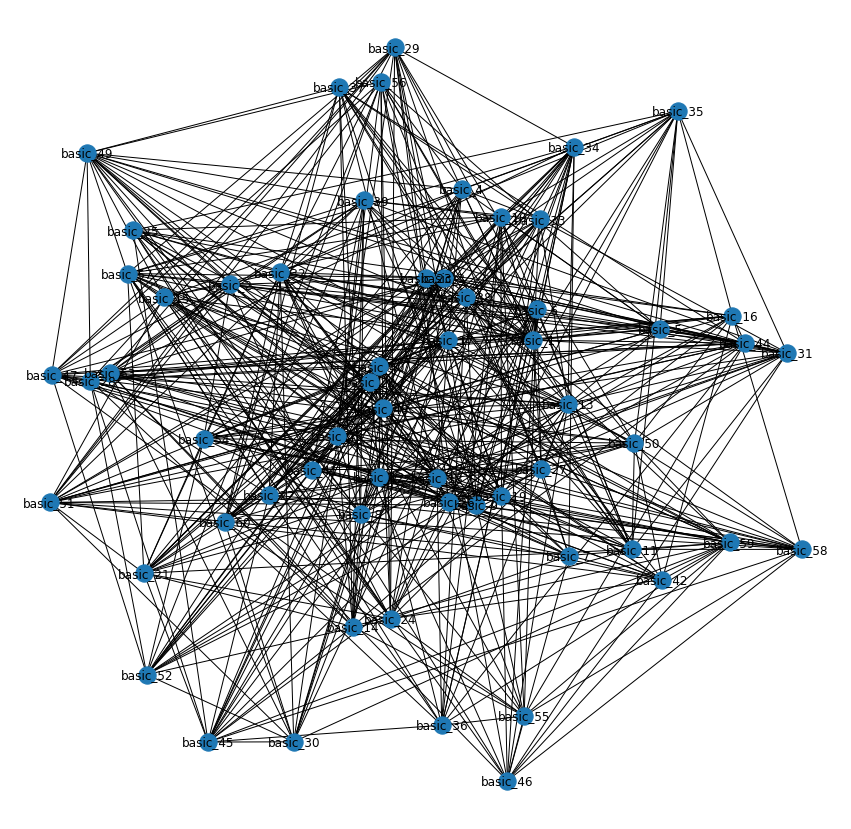

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
from networkx.drawing.nx_agraph import graphviz_layout

from time import time, sleep


G = sim.get_graph()
fig = plt.figure(figsize=(15, 15))
plt.axis('off')
#pos = nx.shell_layout(G)
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(G, pos)

In [ ]:
from simpy import Environment
evn = Environment
School()